# import 

In [1]:
import toml
import json
import time
import torch
import pickle
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.utils import data
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn import Module,Identity,Sequential
from typing import Dict,Tuple
from ecode.m6Anet.blocks import PoolingFilter
from sklearn.metrics import roc_auc_score

# DataLoader

In [4]:
class m6AnetDataset(data.Dataset):
    def __init__(self,path,use_file):
        k5_pos=[[8,13],[9,14],[10,15],[11,16],[12,17]]
        print('using',len(k5_pos),'sites')
        
        samples_dic={}
        k5_list=[]
        with open(path+'/'+use_file+'.txt','r') as f:
            for line in f.readlines():
                f_name,label=line.strip().split()
                with open(path+'/'+f_name+'.index') as f2:
                    for line2 in f2.readlines():
                        sample,start,end=line2.strip().split('\t')
                        if sample not in samples_dic:
                            samples_dic[sample]=[]
                        samples_dic[sample].append((f_name,int(start),int(end),int(label)))
                        with open(path+'/'+f_name+'.json') as f:
                            f.seek(int(start),0)
                            json_str=f.read(int(end)-int(start))
                            Ls=json_str.strip().split('\n')
                            k_str=json.loads(Ls[0])
                            for k5_start,k5_end in k5_pos:
                                k5=k_str[k5_start:k5_end]
                                if k5 not in k5_list:
                                    k5_list.append(k5)
        print('total',len(k5_list),' possible k5 as:')
        print(k5_list)
        self.k5_list=np.array(k5_list)
        
        self.path=path
        self.samples_keys=list(samples_dic.keys())
        self.samples_dic=samples_dic

    def __getitem__(self,index):
        k5_pos=[[8,13],[9,14],[10,15],[11,16],[12,17]]

        R_dicts=[]
        for single_sample in self.samples_dic[self.samples_keys[index]]:
            file,seek_start,seek_end,label=single_sample
            R_dict={'X':[],'kmer':[],'label':label}
            with open(self.path+'/'+file+'.json') as f:
                f.seek(seek_start,0)
                json_str=f.read(seek_end-seek_start)
                Ls=json_str.strip().split('\n')
                k_str=json.loads(Ls[0])
                for k5_start,k5_end in k5_pos:
                    k5=k_str[k5_start:k5_end]
                    R_dict['kmer'].append(np.where(self.k5_list==k5)[0][0])
                for L in Ls[1:]:
                    L_data=json.loads(L)
                    t_feature=[]
                    for each in L_data[10:15]:
                        if each[0]<0:
                            t_feature.extend([0,0,0])
                        else:
                            t_feature.extend(each)
                    R_dict['X'].append(t_feature)
            for key in R_dict:
                R_dict[key]=torch.tensor(R_dict[key])
            R_dict['kmer']=R_dict['kmer'].repeat(len(R_dict['X']),1)
            R_dicts.append(R_dict)
        return R_dicts                
    def __len__(self):
        return len(self.samples_dic)

class FlattenedDataset(data.Dataset):
    def __init__(self,original_dataset):
        self.flattened_data=[]
        for data in original_dataset:
            self.flattened_data.extend(data)
    def __len__(self):
        return len(self.flattened_data)
    def __getitem__(self,index):
        if isinstance(index,(list,np.ndarray)):
            return [self.flattened_data[i] for i in index]
        else:
            return self.flattened_data[index]

In [5]:
dataset=m6AnetDataset('./edata/DataSet/m6A','use_files')
print(len(dataset))
K5_TYPES=len(dataset.k5_list)

using 5 sites
total 206  possible k5 as:
['GTAAA', 'TAAAC', 'AAACT', 'AACTG', 'ACTGA', 'AAGAA', 'AGAAC', 'GAACA', 'AACAT', 'ACATT', 'ATGAA', 'TGAAC', 'ACATG', 'TGGGA', 'GGGAC', 'GGACT', 'GACTG', 'ACTGC', 'ACAGA', 'CAGAC', 'AGACC', 'GACCT', 'ACCTA', 'CCGGA', 'CGGAC', 'GGACA', 'GACAG', 'ACAGG', 'GAGGA', 'AGGAC', 'GACTT', 'ACTTG', 'ATAGA', 'TAGAC', 'AGACT', 'GAACC', 'AACCC', 'ACCCA', 'CAGAA', 'GAACT', 'AACTC', 'ACTCA', 'AAGGA', 'GGACC', 'GACCG', 'ACCGT', 'GTGGA', 'TGGAC', 'GACTA', 'ACTAA', 'CAGGA', 'GACTC', 'ACTCT', 'ACTCG', 'ACGGA', 'ACTTC', 'CTAAC', 'TAACT', 'AACTT', 'ACTTT', 'AATGA', 'ATGAC', 'TGACC', 'GACCC', 'ACCCC', 'GAGAA', 'AACCG', 'CGGGA', 'ACCTG', 'ACCGC', 'ACCTC', 'CTGGA', 'ATGGA', 'GGGGA', 'AGGGA', 'ACAAA', 'CAAAC', 'ACTTA', 'AGAGA', 'GAGAC', 'GCAGA', 'ACTGG', 'CAAGA', 'AAGAC', 'TTGGA', 'ATAAA', 'TCAGA', 'ACCCG', 'GATGA', 'TGACT', 'TCGGA', 'TAGAA', 'AACAG', 'ACAGC', 'AGGAA', 'GGAAC', 'AACAA', 'ACAAT', 'TGGAA', 'GACAC', 'ACACA', 'GACAT', 'ACATC', 'ACAGT', 'TAGGA', 'ACATA', 'ACC

In [11]:
RELOAD=0
if RELOAD==1:
    dataset=m6AnetDataset('./edata/DataSet/m6A','use_files')
    train_size=int(len(dataset)*0.8)
    test_size=len(dataset)-train_size
    train_set,test_set=torch.utils.data.random_split(dataset,[train_size,test_size])
    flattened_train_set=FlattenedDataset(train_set)
    flattened_test_set=FlattenedDataset(test_set)
    print('len(flattened_train_set)',len(flattened_train_set))
    print('len(flattened_test_set)',len(flattened_test_set))

    with open('./edata/Save_DataSet/m6A_m6Anet_5sites_train_set.pkl','wb') as f:
        pickle.dump(flattened_train_set,f)
    with open('./edata/Save_DataSet/m6A_m6Anet_5sites_test_set.pkl','wb') as f:
        pickle.dump(flattened_test_set,f)
    train_loader=DataLoader(flattened_train_set,batch_size=5,shuffle=True)
    test_loader=DataLoader(flattened_test_set,batch_size=5,shuffle=True)
else:
    with open('./edata/Save_DataSet/m6A_m6Anet_5sites_train_set.pkl','rb') as f:
        flattened_train_set=pickle.load(f)
    with open('./edata/Save_DataSet/m6A_m6Anet_5sites_test_set.pkl','rb') as f:
        flattened_test_set=pickle.load(f)
    print('len(flattened_train_set)',len(flattened_train_set))
    print('len(flattened_test_set)',len(flattened_test_set))
    
    train_loader=DataLoader(flattened_train_set,batch_size=5,shuffle=True)
    test_loader=DataLoader(flattened_test_set,batch_size=5,shuffle=True)

using 5 sites
total 206  possible k5 as:
['GTAAA', 'TAAAC', 'AAACT', 'AACTG', 'ACTGA', 'AAGAA', 'AGAAC', 'GAACA', 'AACAT', 'ACATT', 'ATGAA', 'TGAAC', 'ACATG', 'TGGGA', 'GGGAC', 'GGACT', 'GACTG', 'ACTGC', 'ACAGA', 'CAGAC', 'AGACC', 'GACCT', 'ACCTA', 'CCGGA', 'CGGAC', 'GGACA', 'GACAG', 'ACAGG', 'GAGGA', 'AGGAC', 'GACTT', 'ACTTG', 'ATAGA', 'TAGAC', 'AGACT', 'GAACC', 'AACCC', 'ACCCA', 'CAGAA', 'GAACT', 'AACTC', 'ACTCA', 'AAGGA', 'GGACC', 'GACCG', 'ACCGT', 'GTGGA', 'TGGAC', 'GACTA', 'ACTAA', 'CAGGA', 'GACTC', 'ACTCT', 'ACTCG', 'ACGGA', 'ACTTC', 'CTAAC', 'TAACT', 'AACTT', 'ACTTT', 'AATGA', 'ATGAC', 'TGACC', 'GACCC', 'ACCCC', 'GAGAA', 'AACCG', 'CGGGA', 'ACCTG', 'ACCGC', 'ACCTC', 'CTGGA', 'ATGGA', 'GGGGA', 'AGGGA', 'ACAAA', 'CAAAC', 'ACTTA', 'AGAGA', 'GAGAC', 'GCAGA', 'ACTGG', 'CAAGA', 'AAGAC', 'TTGGA', 'ATAAA', 'TCAGA', 'ACCCG', 'GATGA', 'TGACT', 'TCGGA', 'TAGAA', 'AACAG', 'ACAGC', 'AGGAA', 'GGAAC', 'AACAA', 'ACAAT', 'TGGAA', 'GACAC', 'ACACA', 'GACAT', 'ACATC', 'ACAGT', 'TAGGA', 'ACATA', 'ACC

# model

In [26]:
class MILModel(Module):
    def __init__(self,model_config):
        super(MILModel,self).__init__()
        self.model_config=model_config
        self.read_level_encoder=None
        self.pooling_filter=None
        self.decoder=None
        self.build_model()

    def build_model(self):
        blocks=self.model_config['block']
        seq_model=[]
        for block in blocks:
            block_type=block.pop('block_type')
            block_obj=self._build_block(block_type,**block)

            if isinstance(block_obj,PoolingFilter):
                if len(seq_model)>0:
                    self.read_level_encoder=Sequential(*seq_model)
                else:
                    self.read_level_encoder=None

                self.pooling_filter=block_obj
                seq_model=[]
            else:
                seq_model.append(block_obj)

        if (self.read_level_encoder is None) and (self.pooling_filter is None):
            self.read_level_encoder=Sequential(*seq_model)
            self.pooling_filter=Identity()
            self.decoder=Identity()
        else:
            if len(seq_model)==0:
                self.decoder=Identity()
            else:
                self.decoder=Sequential(*seq_model)

    def _build_block(self,block_type,**kwargs):
        from ecode.m6Anet import blocks
        block_obj=getattr(blocks,block_type)
        return block_obj(**kwargs)

    def get_read_representation(self,x):
        if self.read_level_encoder is None:
            return x
        else:
            return self.read_level_encoder(x)

    def get_read_probability(self,x):
        read_representation=self.get_read_representation(x)
        return self.pooling_filter.predict_read_level_prob(read_representation)

    def get_site_representation(self,x):
        return self.pooling_filter(self.get_read_representation(x))

    def get_site_probability(self,x):
        return self.decoder(self.get_site_representation(x))

    def get_read_site_probability(self,x):
        read_representation=self.get_read_representation(x)
        read_level_probability=self.pooling_filter.predict_read_level_prob(read_representation)
        site_level_probability=self.decoder(self.pooling_filter(read_representation))
        return read_level_probability,site_level_probability,read_representation

    def get_attention_weights(self,x):
        if hasattr(self.pooling_filter, "get_attention_weights"):
            return self.pooling_filter.get_attention_weights(self.get_read_representation(x))
        else:
            raise ValueError("Pooling filter does not have attention weights")

    def forward(self,x):
        if type(x) is np.ndarray:
            probs=torch.tensor([]).to(x[0]['X'].device)
            for sub_x in x:
                sub_x={k:v.unsqueeze(0) for k,v in sub_x.items()}
                prob=self.get_site_probability(sub_x).unsqueeze(0)
                probs=torch.cat((probs,prob.unsqueeze(0)),dim=0)
        else:
            probs=self.get_site_probability(x)
        return probs

# For Train and Test

In [14]:
def test(model,test_loader,device,read_reduce=0):
    model.eval()
    right_count,all_count=0,0
    prob_all,Y_all=[],[]
    with torch.no_grad():
        for _,l_dic in enumerate(test_loader):
            l_dic={k:v.to(device) for k, v in l_dic.items()}
            data_y=l_dic['label'].to(torch.int64)
            l_dic['X']=l_dic['X'][:,read_reduce:]
            l_dic['kmer']=l_dic['kmer'][:,read_reduce:]
            pre_y=model(l_dic)
            out_y=pre_y>0.5
            right_count+=out_y.eq(data_y).sum()
            all_count+=len(data_y)
            for each in pre_y:
                prob_all.append(np.array(each.cpu()))
            for each in data_y:
                Y_all.append(np.array(each.cpu()))
    roauc=roc_auc_score(Y_all,prob_all)

    accuracy=100*(right_count/all_count).item()
    print('AUC:{:.4f}   accuracy:{:.4f}%'.format(roauc,accuracy))
    torch.cuda.empty_cache()

def train(model,train_loader,test_loader,device,optimizer,loss_func,epochs,read_reduce=0):
    torch.cuda.empty_cache()
    for epoch in range(epochs):
        total_loss=0
        model.train()
        for _,l_dic in enumerate(train_loader):
            l_dic={k:v.to(device) for k, v in l_dic.items()}
            data_y=l_dic['label']
            l_dic['X']=l_dic['X'][:,read_reduce:]
            l_dic['kmer']=l_dic['kmer'][:,read_reduce:]
            pre_y=model(l_dic)
            loss=loss_func(pre_y,data_y.float())
            total_loss+=loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print('epoch {}, loss:{:.4f}'.format(epoch+1,total_loss.item()/len(train_loader)))
        if epoch%10==9:
            print('At epoch '+str(epoch+1),':')
            test(model,test_loader,device,read_reduce)
            torch.save(model.state_dict(),'./model/model_'+str(epoch+1)+'_'+str(int(time.time()))+'.pkl')

In [15]:
def detailed_test(model,test_loader,device,read_reduce=0,curve_name=None):
    model.eval()
    right_count,all_count=0,0
    more_dict={0.5:[0,0],0.6:[0,0],0.8:[0,0],0.7:[0,0],0.9:[0,0],0.95:[0,0],0.98:[0,0],\
               0.99:[0,0],0.995:[0,0],0.999:[0,0],0.9995:[0,0],0.9999:[0,0],0.99995:[0,0],\
               0.99999:[0,0],0.999995:[0,0],0.999999:[0,0]}
    prob_all,Y_all=[],[]
    motif_found_dict={}
    motif_dict={}
    with torch.no_grad():
        for _,l_dic in enumerate(test_loader):
            l_dic={k:v.to(device) for k, v in l_dic.items()}
            data_y=l_dic['label'].to(torch.int64)
            l_dic['X']=l_dic['X'][:,read_reduce:]
            l_dic['kmer']=l_dic['kmer'][:,read_reduce:]
            pre_y=model(l_dic)
            out_y=pre_y>0.5
            right_count+=out_y.eq(data_y).sum()
            all_count+=len(data_y)
            for each in pre_y:
                prob_all.append(np.array(each.cpu()))
            for each in data_y:
                Y_all.append(np.array(each.cpu()))
            for key in more_dict:
                more_dict[key][0]+=((pre_y>key)&data_y).sum()
                more_dict[key][1]+=(pre_y>key).sum()
    if curve_name:
        save_frame=pd.DataFrame({'label':Y_all,'pred':prob_all})
        save_frame.to_csv('./edata/Save_for_drawing/'+curve_name+'_curve.csv',index=False,sep=',')

    print('Im total',all_count,'samples:')
    auc=roc_auc_score(Y_all,prob_all)
    accuracy=100*(right_count/all_count).item()
    print('AUC:{:.4f}   accuracy:{:.4f}%'.format(auc,accuracy))
    for key in more_dict:
        if more_dict[key][1]>0:
            print('Precision when positive threshold at {:g} is :{:.4f}% (total:{:d})'.format(key,more_dict[key][0]/more_dict[key][1],more_dict[key][1]))
    torch.cuda.empty_cache()

# Train

In [28]:
config_file_5sites_20reads='./ecode/m6Anet/m6Anet_5sites_20reads.toml'
model_config_5sites_20reads=toml.load(config_file_5sites_20reads)
model_config_5sites_20reads['block'][0]['input_channel']=K5_TYPES
device=torch.device('cuda'if torch.cuda.is_available() else 'cpu')
model=MILModel(model_config_5sites_20reads).to(device)
optimizer=optim.Adam(model.parameters(),lr=0.001)
loss_func=nn.BCELoss()
epochs=300
train(model,train_loader,test_loader,device,optimizer,loss_func,epochs,read_reduce=30)

epoch 1, loss:0.7400
epoch 2, loss:0.6436
epoch 3, loss:0.6185
epoch 4, loss:0.6060
epoch 5, loss:0.5947
epoch 6, loss:0.5843
epoch 7, loss:0.5758
epoch 8, loss:0.5661
epoch 9, loss:0.5524
epoch 10, loss:0.5514
At epoch 10 :
AUC:0.7984   accuracy:70.6165%
epoch 11, loss:0.5491
epoch 12, loss:0.5374
epoch 13, loss:0.5312
epoch 14, loss:0.5312
epoch 15, loss:0.5255
epoch 16, loss:0.5259
epoch 17, loss:0.5139
epoch 18, loss:0.5158
epoch 19, loss:0.5141
epoch 20, loss:0.5053
At epoch 20 :
AUC:0.8118   accuracy:74.2994%
epoch 21, loss:0.5156
epoch 22, loss:0.5074
epoch 23, loss:0.5107
epoch 24, loss:0.5020
epoch 25, loss:0.4943
epoch 26, loss:0.4978
epoch 27, loss:0.4896
epoch 28, loss:0.4931
epoch 29, loss:0.4905
epoch 30, loss:0.4889
At epoch 30 :
AUC:0.7995   accuracy:71.0168%
epoch 31, loss:0.4916
epoch 32, loss:0.4845
epoch 33, loss:0.4829
epoch 34, loss:0.4871
epoch 35, loss:0.4812
epoch 36, loss:0.4789
epoch 37, loss:0.4711
epoch 38, loss:0.4794
epoch 39, loss:0.4752
epoch 40, loss:0

# Test

In [30]:
config_file_5sites_20reads='./ecode/m6Anet/m6Anet_5sites_20reads.toml'
model_config_5sites_20reads=toml.load(config_file_5sites_20reads)
model_config_5sites_20reads['block'][0]['input_channel']=K5_TYPES
device=torch.device('cuda'if torch.cuda.is_available() else 'cpu')
model=MILModel(model_config_5sites_20reads).to(device)
model.load_state_dict(torch.load('./model/m6Anet_40_20reads_5sites.pkl',weights_only=True))
detailed_test(model,test_loader,device,read_reduce=30,curve_name='m6Anet,20reads_5sites')

Im total 1249 samples:
AUC:0.8201   accuracy:69.6557%
Precision when positive threshold at 0.5 is :0.6418% (total:871)
Precision when positive threshold at 0.6 is :0.6953% (total:745)
Precision when positive threshold at 0.8 is :0.8202% (total:456)
Precision when positive threshold at 0.7 is :0.7697% (total:595)
Precision when positive threshold at 0.9 is :0.8736% (total:277)
Precision when positive threshold at 0.95 is :0.8854% (total:157)
Precision when positive threshold at 0.98 is :0.9437% (total:71)
Precision when positive threshold at 0.99 is :0.9500% (total:40)
Precision when positive threshold at 0.995 is :0.9565% (total:23)
Precision when positive threshold at 0.999 is :1.0000% (total:9)
Precision when positive threshold at 0.9995 is :1.0000% (total:3)
Precision when positive threshold at 0.9999 is :1.0000% (total:1)
Precision when positive threshold at 0.99995 is :1.0000% (total:1)


In [35]:
config_file_20reads='./ecode/m6Anet/m6Anet_20reads.toml'
model_config_20reads=toml.load(config_file_20reads)
model_config_20reads['block'][0]['input_channel']=K5_TYPES
device=torch.device('cuda'if torch.cuda.is_available() else 'cpu')
model_20reads=MILModel(model_config_20reads).to(device)
model_20reads.load_state_dict(torch.load('./model/m6Anet_240_20reads_3sites.pkl',weights_only=True))

<All keys matched successfully>

In [36]:
explainer_20reads=m6Anet_DeepEXP(model_20reads,background_set_20reads)
shap_values_20reads=explainer_20reads.shap_values(sample_set_20reads)
shap_values_20reads=np.array(shap_values_20reads[0])
shap_values_20reads=shap_values_20reads.reshape(shap_values_20reads.shape[:-1])

[6.306194e-01 1.741457e-01 8.164712e-02 3.790598e-02 2.529633e-02
 1.578703e-02 1.071474e-02 7.844990e-03 5.300277e-03 3.597001e-03
 2.174671e-03 1.532282e-03 1.216910e-03 8.871732e-04 6.098652e-04
 4.369144e-04 2.309820e-04 4.628708e-05 6.318925e-06 0.000000e+00]


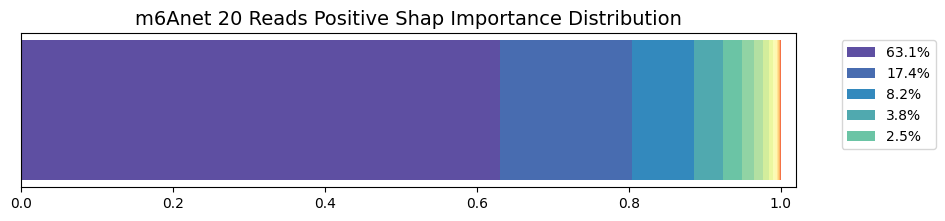

positive shap gini for 20reads is: 0.8590317


In [45]:
shap_use=shap_values_20reads.copy()
shap_use[shap_values_20reads<0]=0
row_sums=shap_use.sum(axis=1,keepdims=True)
row_sums[row_sums==0]=1
normalized_shap_use=shap_use/row_sums
sorted_normalized_shap_use=np.sort(normalized_shap_use,axis=1)[:,::-1]

#importance distribution by the top N most important read by positive shap
importance_20reads=sorted_normalized_shap_use.sum(axis=0,keepdims=False)/normalized_shap_use.sum()
print(importance_20reads)

cmap=plt.colormaps.get_cmap('Spectral')
colors=cmap(np.linspace(1,0,len(importance_20reads)))
fig,ax=plt.subplots(figsize=(10,2))

left=0
for i,(imp,color) in enumerate(zip(importance_20reads,colors)):
    if i<5:
        label_use=f'{imp*100:.1f}%'
    else:
        label_use=None
    ax.barh(0,width=imp,left=left,height=0.5,color=color,label=label_use)
    left+=imp
ax.set_yticks([])
ax.set_xlim([0,1.02])
ax.set_title('m6Anet 20 Reads Positive Shap Importance Distribution',fontsize=14)
ax.legend(bbox_to_anchor=(1.05,1),loc='upper left')
plt.savefig('./edata/Save_drawing/m6Anet_positive_shap_distribution_20reads.pdf',bbox_inches='tight')
plt.show()

gini_20reads=gini_coefficient(importance_20reads)
print('positive shap gini for 20reads is:',gini_20reads.cpu().numpy())

[0.103908 0.078055 0.070646 0.065604 0.062001 0.059196 0.056639 0.054918
 0.052549 0.05052  0.048426 0.045812 0.043644 0.041606 0.038506 0.035296
 0.031464 0.026967 0.021227 0.013017]


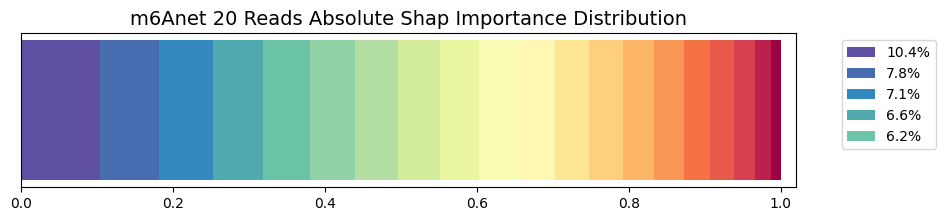

absolute shap gini for 20reads is: 0.22279584


In [42]:
shap_abs=abs(shap_values_20reads)
row_sums=shap_abs.sum(axis=1,keepdims=True)
normalized_shap_abs=shap_abs/row_sums
sorted_normalized_shap_abs=np.sort(normalized_shap_abs,axis=1)[:,::-1]

#importance distribution by the top N most important read by absolute shap
importance_20reads=sorted_normalized_shap_abs.mean(axis=0,keepdims=False)
print(importance_20reads)

cmap=plt.colormaps.get_cmap('Spectral')
colors=cmap(np.linspace(1,0,len(importance_20reads)))
fig,ax=plt.subplots(figsize=(10,2))

left=0
for i,(imp,color) in enumerate(zip(importance_20reads,colors)):
    if i<5:
        label_use=f'{imp*100:.1f}%'
    else:
        label_use=None
    ax.barh(0,width=imp,left=left,height=0.5,color=color,label=label_use)
    left+=imp
ax.set_yticks([])
ax.set_xlim([0,1.02])
ax.set_title('m6Anet 20 Reads Absolute Shap Importance Distribution',fontsize=14)
ax.legend(bbox_to_anchor=(1.05,1),loc='upper left')
plt.savefig('./edata/Save_drawing/m6Anet_absolute_shap_distribution_20reads.pdf',bbox_inches='tight')
plt.show()

gini_20reads=gini_coefficient(importance_20reads)
print('absolute shap gini for 20reads is:',gini_20reads.cpu().numpy())

In [37]:
scaler=RobustScaler()

flattened_data=shap_values_20reads.flatten()
scaled_flattened_data=scaler.fit_transform(flattened_data.reshape(-1,1)).flatten()
scaled_shap_values_20reads=scaled_flattened_data.reshape(shap_values_20reads.shape)

pre_Y_list=[]
real_Y_list=[]
for i in range(len(scaled_shap_values_20reads)):
    c_X=sample_set_20reads[i].copy()
    for key in ['X','kmer']:
        c_X[key]=c_X[key].unsqueeze(0)
    pre_Y=model_20reads(c_X)[0].cpu().detach().numpy()
    pre_Y_list.append(pre_Y)
    real_Y=c_X['label'].cpu().detach().numpy()
    real_Y_list.append(real_Y)
    print('predicted label for sample',i,'is:',pre_Y)
    print('real label for sample',i,'is:',real_Y)
    print(f'shap_values for sample {i} is:\n {scaled_shap_values_20reads[i]}')
pre_Y_list=np.array(pre_Y_list)
real_Y_list=np.array(real_Y_list)

predicted label for sample 0 is: 0.929291
real label for sample 0 is: 1
shap_values for sample 0 is:
 [-3.577668 -3.806446  1.550404  0.62169  -3.806446  8.567173  1.550404
 -2.102527  3.083536 -0.162079 -2.102527 -0.162079 -3.673568  3.465142
  0.566431  4.223116 -3.673568  1.550404 -3.814381  8.567173]
predicted label for sample 1 is: 0.27383047
real label for sample 1 is: 0
shap_values for sample 1 is:
 [-0.005701 -0.010908 -0.009477 -0.010658 -0.01116  -0.007117 -0.010967
  0.003984 -0.009986 -0.01004  -0.009684 -0.004789 -0.007024 -0.011163
 -0.011146 -0.01083  -0.005483  0.285043 -0.010203 -0.009899]
predicted label for sample 2 is: 0.9577416
real label for sample 2 is: 1
shap_values for sample 2 is:
 [ 0.619487 -0.586501 -0.603125 -0.399408 -0.529914  2.189503 -0.443919
  1.131264  0.827358 -0.59471   0.134847 -0.580067 -0.593963 -0.398729
 -0.541124  1.106642 -0.59405  -0.108483 -0.571034 -0.316254]
predicted label for sample 3 is: 0.99387044
real label for sample 3 is: 1
shap_

Showing reads with the highest shap values and the status of its corrensponding sample.
Of top 20 shap values, 15 of them distributed in samples with a predicted value higher than 0.7
While of all 200 samples, 110 of them have a predicted value higher than 0.7


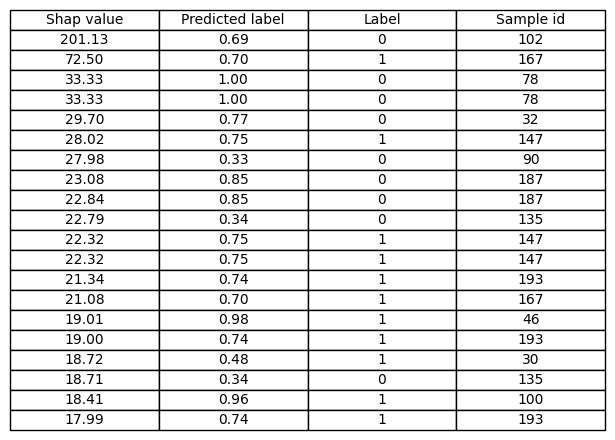

In [48]:
scaler=RobustScaler()
flattened_data=shap_values_20reads.flatten()
scaled_flattened_data=scaler.fit_transform(flattened_data.reshape(-1,1)).flatten()
scaled_shap_values_20reads=scaled_flattened_data.reshape(shap_values_20reads.shape)

pre_Y_list=[]
real_Y_list=[]
for i in range(len(scaled_shap_values_20reads)):
    c_X=sample_set_20reads[i].copy()
    for key in ['X','kmer']:
        c_X[key]=c_X[key].unsqueeze(0)
    pre_Y=model_20reads(c_X)[0].cpu().detach().numpy()
    pre_Y_list.append(pre_Y)
    real_Y=c_X['label'].cpu().detach().numpy()
    real_Y_list.append(real_Y)
pre_Y_list=np.array(pre_Y_list)
real_Y_list=np.array(real_Y_list)

TOP_N=20
Threshold=0.7
print('Showing reads with the highest shap values and the status of its corrensponding sample.')
flattened_shap_values_20reads=scaled_shap_values_20reads.flatten()
top_indices=np.argsort(flattened_shap_values_20reads)[-TOP_N:]
rows,cols=np.unravel_index(top_indices,scaled_shap_values_20reads.shape)
high_value_count=0


shap_list=[]
predicted_list=[]
label_list=[]
sample_list=[]
for row,col in zip(rows[::-1],cols[::-1]):
    shap_list.append(scaled_shap_values_20reads[row,col])
    predicted_list.append(pre_Y_list[row])
    label_list.append(real_Y_list[row])
    sample_list.append(row)
    if pre_Y_list[row]>=Threshold:
        high_value_count+=1
print(f'Of top {TOP_N} shap values, {high_value_count} of them distributed in samples with a predicted value higher than {Threshold}')
print(f'While of all {len(pre_Y_list)} samples, {(pre_Y_list>Threshold).sum()} of them have a predicted value higher than {Threshold}')

fig,ax=plt.subplots()
ax.axis('tight')
ax.axis('off')
column_names=('Shap value','Predicted label','Label','Sample id')
textdata=np.array([shap_list,predicted_list,label_list,sample_list]).T

formatted_data=[]
for row in textdata:
    formatted_row=[f'{val:.2f}' for val in row[:-2]] + [int(val) for val in row[-2:]]
    formatted_data.append(formatted_row)

table=ax.table(cellText=formatted_data,colLabels=column_names,loc='center')
for key,cell in table.get_celld().items():
    cell.set_text_props(ha='center',va='center')

table.scale(1.2,1.2)
plt.savefig('./edata/Save_drawing/m6Anet_shap_table.pdf',bbox_inches='tight')
plt.show()

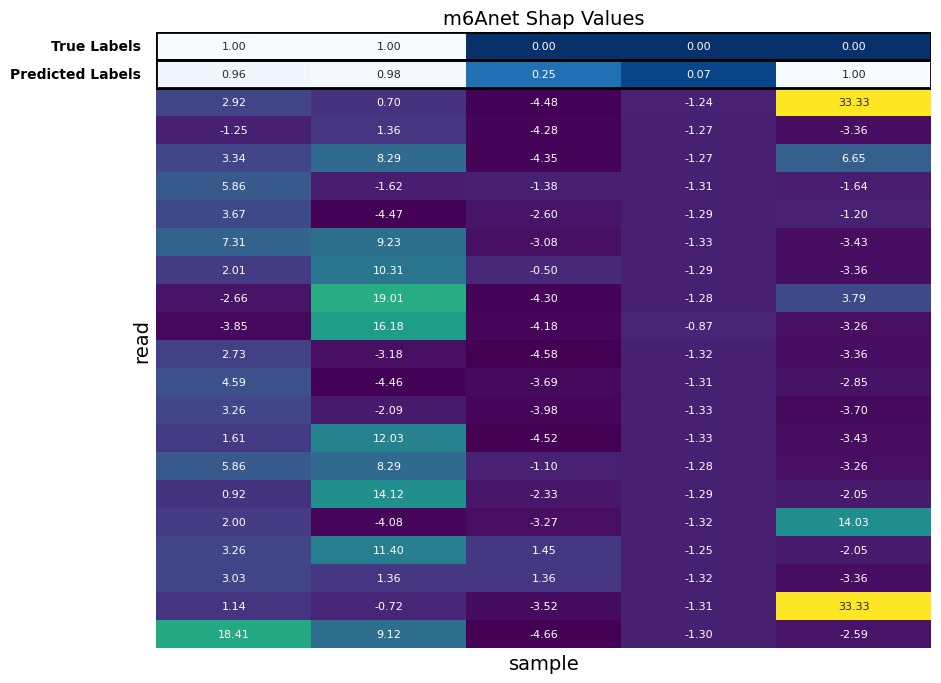

In [46]:
picked_for_showing=[100,46,44,80,78]

picked_real_Y=real_Y_list[picked_for_showing]
picked_pre_Y=pre_Y_list[picked_for_showing]
picked_reads_shap=scaled_shap_values_20reads[picked_for_showing].T
arr=np.vstack((picked_real_Y,picked_pre_Y,picked_reads_shap))

plt.figure(figsize=(10,8))

mask=np.zeros_like(arr,dtype=bool)
mask[2:]=True
sns.heatmap(arr, annot=True, fmt=".2f",cmap='Blues_r',cbar=False,annot_kws={"size":8}, mask=mask)
sns.heatmap(arr, annot=True, fmt=".2f",cmap='viridis',cbar=False,annot_kws={"size":8}, mask=~mask)
plt.text(-0.1,0.5,'True Labels',va='center',ha='right',fontsize=10,fontweight='bold',color='black')
plt.text(-0.1,1.5,'Predicted Labels',va='center',ha='right',fontsize=10,fontweight='bold',color='black')

rect1=Rectangle((0,0),arr.shape[1],1,linewidth=2,edgecolor='black',facecolor='none')
rect2=Rectangle((0,1),arr.shape[1],1,linewidth=2,edgecolor='black',facecolor='none')
ax=plt.gca()
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.set_xticks([])
ax.set_yticks([])

plt.title('m6Anet Shap Values',fontsize=14)
plt.xlabel('sample',fontsize=14)
plt.ylabel('read',fontsize=14)
plt.savefig('./edata/Save_drawing/m6Anet_shap_20reads_showcase.pdf',bbox_inches='tight')
plt.show()

In [29]:
device=torch.device('cuda:0')
read_reduce=0

background_set_50reads=[]
sample_set_50reads=[]

background_set_size=1000
sample_set_size=200
shuffled_flattened_train_set=flattened_train_set[random.sample(range(len(flattened_train_set)),background_set_size)]
shuffled_flattened_test_set=flattened_test_set[random.sample(range(len(flattened_test_set)),sample_set_size)]

for i in range(background_set_size):
    ap_dic=shuffled_flattened_train_set[i].copy()
    for k,v in ap_dic.items():
        if k=='X' or k=='kmer':
            v=v[read_reduce:]
        v=v.to(device)
        ap_dic[k]=v
    background_set_50reads.append(ap_dic)

for i in range(sample_set_size):
    ap_dic=shuffled_flattened_test_set[i].copy()
    for k,v in ap_dic.items():
        if k=='X' or k=='kmer':
            v=v[read_reduce:]
        v=v.to(device)
        ap_dic[k]=v
    sample_set_50reads.append(ap_dic)

background_set_50reads=np.array(background_set_50reads)
sample_set_50reads=np.array(sample_set_50reads)

In [30]:
config_file_50reads='./ecode/m6Anet/m6Anet_50reads.toml'
model_config_50reads=toml.load(config_file_50reads)
model_config_50reads['block'][0]['input_channel']=K5_TYPES
device=torch.device('cuda:0')
model_50reads=MILModel(model_config_50reads).to(device)
model_50reads.load_state_dict(torch.load('./model/m6Anet_140_50reads_3sites.pkl',weights_only=True))

<All keys matched successfully>

In [31]:
explainer_50reads=m6Anet_DeepEXP(model_50reads,background_set_50reads)
shap_values_50reads=explainer_50reads.shap_values(sample_set_50reads)
shap_values_50reads=np.array(shap_values_50reads[0])
shap_values_50reads=shap_values_50reads.reshape(shap_values_50reads.shape[:-1])

[5.221407e-01 1.744701e-01 7.933383e-02 5.447043e-02 3.471762e-02
 2.586855e-02 2.021920e-02 1.487955e-02 1.066828e-02 8.543413e-03
 6.974179e-03 6.012590e-03 4.848809e-03 4.246739e-03 3.722527e-03
 3.226428e-03 2.751652e-03 2.327546e-03 2.037980e-03 1.850294e-03
 1.559395e-03 1.463783e-03 1.397268e-03 1.290176e-03 1.183317e-03
 1.072539e-03 1.008858e-03 8.948942e-04 8.533265e-04 7.988976e-04
 7.128468e-04 6.015270e-04 5.444483e-04 4.997402e-04 4.417897e-04
 3.944577e-04 3.617361e-04 3.267034e-04 2.732913e-04 2.478865e-04
 2.129079e-04 1.727506e-04 1.255011e-04 9.791082e-05 8.549499e-05
 4.794434e-05 2.006111e-05 6.111951e-08 0.000000e+00 0.000000e+00]


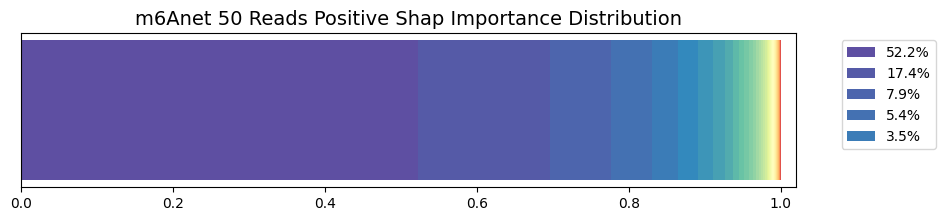

positive shap gini for 50reads is: 0.89549744


In [44]:
shap_use=shap_values_50reads.copy()
shap_use[shap_values_50reads<0]=0
row_sums=shap_use.sum(axis=1,keepdims=True)
row_sums[row_sums==0]=1
normalized_shap_use=shap_use/row_sums
sorted_normalized_shap_use=np.sort(normalized_shap_use,axis=1)[:,::-1]

#importance distribution by the top N most important read by positive shap
importance_50reads=sorted_normalized_shap_use.sum(axis=0,keepdims=False)/normalized_shap_use.sum()
print(importance_50reads)

cmap=plt.colormaps.get_cmap('Spectral')
colors=cmap(np.linspace(1,0,len(importance_50reads)))
fig,ax=plt.subplots(figsize=(10,2))

left=0
for i,(imp,color) in enumerate(zip(importance_50reads,colors)):
    if i<5:
        label_use=f'{imp*100:.1f}%'
    else:
        label_use=None
    ax.barh(0,width=imp,left=left,height=0.5,color=color,label=label_use)
    left+=imp
ax.set_yticks([])
ax.set_xlim([0,1.02])
ax.set_title('m6Anet 50 Reads Positive Shap Importance Distribution',fontsize=14)
ax.legend(bbox_to_anchor=(1.05,1),loc='upper left')
plt.savefig('./edata/Save_drawing/m6Anet_positive_shap_distribution_50reads.pdf',bbox_inches='tight')
plt.show()

gini_50reads=gini_coefficient(importance_50reads)
print('positive shap gini for 50reads is:',gini_50reads.cpu().numpy())

[0.062341 0.03887  0.032859 0.031119 0.028514 0.027253 0.026471 0.025632
 0.025247 0.024735 0.024314 0.023978 0.023572 0.023271 0.02298  0.022647
 0.022282 0.021919 0.021655 0.02134  0.02108  0.020773 0.02048  0.020195
 0.019877 0.019565 0.019229 0.018933 0.018631 0.018305 0.017887 0.017501
 0.017118 0.016691 0.016259 0.015761 0.015326 0.014876 0.014363 0.01384
 0.013175 0.012437 0.011738 0.010982 0.010094 0.009327 0.008257 0.007046
 0.005625 0.003631]


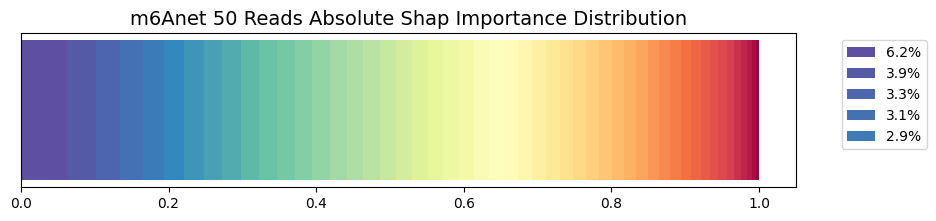

absolute shap gini for 50reads is: 0.2285347


In [40]:
shap_abs=abs(shap_values_50reads)
row_sums=shap_abs.sum(axis=1,keepdims=True)
normalized_shap_abs=shap_abs/row_sums
sorted_normalized_shap_abs=np.sort(normalized_shap_abs,axis=1)[:,::-1]

#importance distribution by the top N most important read by absolute shap
importance_50reads=sorted_normalized_shap_abs.mean(axis=0,keepdims=False)
print(importance_50reads)

cmap=plt.colormaps.get_cmap('Spectral')
colors=cmap(np.linspace(1,0,len(importance_50reads)))
fig,ax=plt.subplots(figsize=(10,2))

left=0
for i,(imp,color) in enumerate(zip(importance_50reads,colors)):
    if i<5:
        label_use=f'{imp*100:.1f}%'
    else:
        label_use=None
    ax.barh(0,width=imp,left=left,height=0.5,color=color,label=label_use)
    left+=imp
ax.set_yticks([])
ax.set_title('m6Anet 50 Reads Absolute Shap Importance Distribution',fontsize=14)
ax.legend(bbox_to_anchor=(1.05,1),loc='upper left')
plt.savefig('./edata/Save_drawing/m6Anet_absolute_shap_distribution_50reads.pdf',bbox_inches='tight')
plt.show()

gini_50reads=gini_coefficient(importance_50reads)
print('absolute shap gini for 50reads is:',gini_50reads.cpu().numpy())